In [1]:
import time
import itertools
from collections import Counter

import pandas as pd
import numpy as np

import pickle

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import KFold, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 42
version = 1

In [2]:
bad_cntr = pd.read_csv('../data/1/2-yarobl_bad_contracts.csv')
good_cntr = pd.read_csv('../data/1/2-yarobl_good_contracts.csv')
data = bad_cntr.append(good_cntr)
data = data.dropna()
data = shuffle(data, random_state=random_seed)
print(data.shape)
data.head(5)

# Экспорт датасета
data.to_csv(path_or_buf='../data/dataset_v{}.csv'.format(version), encoding='utf-8')

(11907, 20)


## Предобработка данных

### Нормирование

In [3]:
column_names = data.loc[:,data.columns != 'cntr_result'].columns
scaler = StandardScaler()
columns_to_normalize = ['org_cntr_num', 'sup_cntr_num', 'sup_cntr_avg_price']

def preprocess_X(df):
    '''Формирование массива признаков'''
    X = df.drop(['cntrID', 'cntr_result'], axis=1)
    X.loc[X['pmp']==0, 'pmp'] = 1
    X.loc[X['price']==0, 'price'] = 1
    X['pmp'] = np.log(X['pmp'])
    X['price'] = np.log(X['price'])
    X.loc[:, columns_to_normalize] = scaler.fit_transform(X.loc[:, columns_to_normalize])
    return X.values

X = preprocess_X(data)
y = data.cntr_result.values

## Обучение нескольких моделей
- Logistic Regression
- Gradient Boosting
- CatBoost
- XGBClassifier

Обучение CatBoost происходит на данных без обработки категориальных переменных. Обучение остальных алгоритмов на данных с предобработанными категориальными переменными.

In [4]:
def save_model(clf, clf_name, version=version):
    """Сохранение модели"""
    with open('model/{}{}_mdl.pkl'.format(clf_name, version), 'wb') as file:
        pickle.dump(clf, file)
        
def save_scaler(scl, version=version):
    with open('model/skaler{}.pkl'.format(version), 'wb') as file:
        pickle.dump(scl, file)

def load_model(clf_name, version=version):
    """Загрузка модели"""
    with open('model/{}{}_mdl.pkl'.format(clf_name, version), 'rb') as file:
        return pickle.load(file)
    
def load_scaler(version=version):
    with open('model/skaler{}.pkl'.format(version), 'rb') as file:
        return pickle.load(file)

In [5]:
save_scaler(scaler)

In [6]:
gb_y_train_real = np.array([])
gb_y_test_real = np.array([])
gb_y_train_pred = np.array([])
gb_y_test_pred = np.array([])
gb_y_test_pred_proba = np.zeros((0, 2))

reg_y_train_real = np.array([])
reg_y_test_real = np.array([])
reg_y_train_pred = np.array([])
reg_y_test_pred = np.array([])
reg_y_test_pred_proba = np.zeros((0, 2))

cb_y_train_real = np.array([])
cb_y_test_real = np.array([])
cb_y_train_pred = np.array([])
cb_y_test_pred = np.array([])
cb_y_test_pred_proba = np.zeros((0, 2))

xgb_y_train_real = np.array([])
xgb_y_test_real = np.array([])
xgb_y_train_pred = np.array([])
xgb_y_test_pred = np.array([])
xgb_y_test_pred_proba = np.zeros((0, 2))

In [7]:
reg = LogisticRegression()
gb = GradientBoostingClassifier(random_state=random_seed)
cb = CatBoostClassifier(logging_level='Silent', random_state=random_seed)
xgb = XGBClassifier()

In [8]:
%%time
start_time = time.time()
kfold_generator = KFold(n_splits=10, shuffle=True, random_state=random_seed)

for idx, (train_index, test_index) in enumerate(kfold_generator.split(X)): 
    print('Обучение {} разбиения'.format(idx + 1))
    
    X_train = X[train_index]
    X_test = X[test_index]
    
    y_train = y[train_index]
    y_test = y[test_index]
    
    
    reg.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    cb.fit(X_train, y_train, cat_features=[11, 12, 17])
    xgb.fit(X_train, y_train)

    reg_y_train_real = np.concatenate((reg_y_train_real, y_train))
    reg_y_test_real = np.concatenate((reg_y_test_real, y_test))
    reg_y_train_pred = np.concatenate((reg_y_train_pred, reg.predict(X_train)))
    reg_y_test_pred = np.concatenate((reg_y_test_pred, reg.predict(X_test)))
    reg_y_test_pred_proba = np.concatenate((reg_y_test_pred_proba, reg.predict_proba(X_test))) 
    
    gb_y_train_real = np.concatenate((gb_y_train_real, y_train))
    gb_y_test_real = np.concatenate((gb_y_test_real, y_test))
    gb_y_train_pred = np.concatenate((gb_y_train_pred, gb.predict(X_train)))
    gb_y_test_pred = np.concatenate((gb_y_test_pred, gb.predict(X_test)))
    gb_y_test_pred_proba = np.concatenate((gb_y_test_pred_proba, gb.predict_proba(X_test)))
    
    cb_y_train_real = np.concatenate((cb_y_train_real, y_train))
    cb_y_test_real = np.concatenate((cb_y_test_real, y_test))
    cb_y_train_pred = np.concatenate((cb_y_train_pred, cb.predict(X_train)))
    cb_y_test_pred = np.concatenate((cb_y_test_pred, cb.predict(X_test)))
    cb_y_test_pred_proba = np.concatenate((cb_y_test_pred_proba, cb.predict_proba(X_test)))
    
    xgb_y_train_real = np.concatenate((xgb_y_train_real, y_train))
    xgb_y_test_real = np.concatenate((xgb_y_test_real, y_test))
    xgb_y_train_pred = np.concatenate((xgb_y_train_pred, xgb.predict(X_train)))
    xgb_y_test_pred = np.concatenate((xgb_y_test_pred, xgb.predict(X_test)))
    xgb_y_test_pred_proba = np.concatenate((xgb_y_test_pred_proba, xgb.predict_proba(X_test))) 

print('Обучение заняло %s секунд' % int(time.time() - start_time))

save_model(reg, 'lr')
save_model(gb, 'gb')
save_model(cb, 'cb')
save_model(xgb, 'gb')

Обучение 1 разбиения
Обучение 2 разбиения
Обучение 3 разбиения
Обучение 4 разбиения
Обучение 5 разбиения
Обучение 6 разбиения
Обучение 7 разбиения
Обучение 8 разбиения
Обучение 9 разбиения
Обучение 10 разбиения
Обучение заняло 225 секунд
CPU times: user 12min 45s, sys: 47.7 s, total: 13min 33s
Wall time: 3min 45s


## Функции для анализа результатов

In [9]:
def print_classifier_info(clf_name, y_train_real, y_train_pred, y_test_real, y_test_pred, y_test_pred_proba):
    """Презентация основной информации об обученной модели"""
    
    print_str = (
        '{0}\n{1}\n{2}\nТочность {3:.3f} на обучающей выборке\n'
        'Точность {4:.3f} на тестовой выборке\n'
        'Потеря перекрестной энтропии {5:.3f}\n{1}\n'
    ).format(
        clf_name.upper(),
        "=" * 55 + '\n',
        classification_report(y_test_real, y_test_pred, target_names=('Плохой', 'Хороший')),
        accuracy_score(y_train_real, y_train_pred),
        accuracy_score(y_test_real, y_test_pred),
        log_loss(y_test_real[:len(y_test_pred_proba)], y_test_pred_proba)
    )
    print(print_str)

def real_and_predicted_correlation(y_test_real, y_test_pred, y_test_pred_proba):
    """Корреляция для реальных и предсказываемых значений"""
    data = pd.DataFrame({'result': y_test_real}).join(
        pd.DataFrame({'proba_pred':y_test_pred_proba[:,0]}).join(
            pd.DataFrame({'pred': y_test_pred})
        )
    )
    return data, data.corr()

def plot_confusion_matrix(
    cm, classes, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues
):
    """Построение матрицы ошибок"""
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Истинное значение')
    plt.xlabel('Предсказываемое значение')
    plt.show()
    
def plot_dependence(res, title=None):
    """
    Построение распределения контрактов по предсказываемой классификатором вероятности
    относения наблюдения к плохому классу
    """
    
    counter0 = Counter() # счетчик плохих контрактов
    counter1 = Counter() # счетчик хороших контрактов

    for index, row in res.iterrows():
        proba = round(row['proba_pred'], 2)

        if not row['result']:
            counter0[proba] += 1
        else:
            counter1[proba] += 1
    
    corr_df0 = pd.DataFrame.from_dict(counter0, orient='index').reset_index().sort_values(['index'])
    corr_df1 = pd.DataFrame.from_dict(counter1, orient='index').reset_index().sort_values(['index'])
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)

    ax.plot(corr_df0['index'], corr_df0[0])
    ax.plot(corr_df1['index'], corr_df1[0])

    plt.legend(['Плохие контракты', 'Хорошие контракты'], loc='upper left')
    plt.xlabel('Предсказываемая вероятность плохого исхода')
    plt.ylabel('Реальное количество контрактов')
    if title:
        plt.title(title)
    plt.show()

def plot_roc_curve(y_test_real, y_test_pred):
    """Построение ROC-кривой"""
    
    fpr, tpr, threshold = roc_curve(y_test_real, y_test_pred)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--', label='Удача')
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

In [10]:
def learn_one_model(classifier, clf_name, kfold=10):
    """Функция для обучения одной модели"""
    
    start_time = time.time()

    y_train_real = np.array([])
    y_test_real = np.array([])
    y_train_pred = np.array([])
    y_test_pred = np.array([])
    y_test_pred_proba = np.zeros((0, 2))
    
    kfolds_generator = KFold(n_splits=kfold, shuffle=True, random_state=random_seed)
    
    for idx, (train_index, test_index) in enumerate(kfolds_generator.split(X)):
        print('Обучение {} разбиения'.format(idx + 1))
        
        X_train = X[train_index]
        X_test = X[test_index]
    
        y_train = y[train_index]
        y_test = y[test_index]
    
        classifier.fit(X_train, y_train)
    
        y_train_real = np.concatenate((y_train_real, y_train))
        y_test_real = np.concatenate((y_test_real, y_test))
        y_train_pred = np.concatenate((y_train_pred, classifier.predict(X_train)))
        y_test_pred = np.concatenate((y_test_pred, classifier.predict(X_test)))
        y_test_pred_proba = np.concatenate((y_test_pred_proba, classifier.predict_proba(X_test))) 
    print("Обучение заняло %s секунд\n" % (time.time() - start_time))
    print_classifier_info(clf_name, y_train_real, y_train_pred, y_test_real, y_test_pred, y_test_pred_proba)
    res, res_corr = real_and_predicted_correlation(y_test_real, y_test_pred, y_test_pred_proba)
    print(res_corr)
    plot_confusion_matrix(
        confusion_matrix(y_test_real, y_test_pred), 
        classes=classifier.classes_, 
        # normalize=True,
        title='Confusion matrix, without normalization'
    )
    plot_dependence(res)
    plot_roc_curve(y_test_real, y_test_pred)
    return classifier

## Анализ результатов

In [11]:
print_classifier_info(
    "Logistic Regression", reg_y_train_real, reg_y_train_pred, 
    reg_y_test_real, reg_y_test_pred, reg_y_test_pred_proba
)
print_classifier_info(
    "Gradient Boosting Classifier", gb_y_train_real, gb_y_train_pred, 
    gb_y_test_real, gb_y_test_pred, gb_y_test_pred_proba
)
print_classifier_info(
    "CatBoost", cb_y_train_real, cb_y_train_pred, 
    cb_y_test_real, cb_y_test_pred, cb_y_test_pred_proba
)
print_classifier_info(
    "XGBoost", xgb_y_train_real, xgb_y_train_pred, 
    xgb_y_test_real, xgb_y_test_pred, xgb_y_test_pred_proba
)

LOGISTIC REGRESSION

             precision    recall  f1-score   support

     Плохой       0.98      0.35      0.52      5926
    Хороший       0.61      0.99      0.75      5981

avg / total       0.79      0.68      0.64     11907

Точность 0.675 на обучающей выборке
Точность 0.675 на тестовой выборке
Потеря перекрестной энтропии 0.619


GRADIENT BOOSTING CLASSIFIER

             precision    recall  f1-score   support

     Плохой       0.95      0.89      0.92      5926
    Хороший       0.90      0.96      0.93      5981

avg / total       0.93      0.93      0.93     11907

Точность 0.930 на обучающей выборке
Точность 0.926 на тестовой выборке
Потеря перекрестной энтропии 0.204


CATBOOST

             precision    recall  f1-score   support

     Плохой       0.97      0.92      0.94      5926
    Хороший       0.92      0.97      0.95      5981

avg / total       0.95      0.95      0.95     11907

Точность 0.959 на обучающей выборке
Точность 0.947 на тестовой выборке
Потеря 

In [12]:
reg_res, reg_res_corr = real_and_predicted_correlation(reg_y_test_real, reg_y_test_pred, reg_y_test_pred_proba)
gb_res, gb_res_corr = real_and_predicted_correlation(gb_y_test_real, gb_y_test_pred, gb_y_test_pred_proba)
cb_res, cb_res_corr = real_and_predicted_correlation(cb_y_test_real, cb_y_test_pred, cb_y_test_pred_proba)
xgb_res, xgb_res_corr = real_and_predicted_correlation(xgb_y_test_real, xgb_y_test_pred, xgb_y_test_pred_proba)

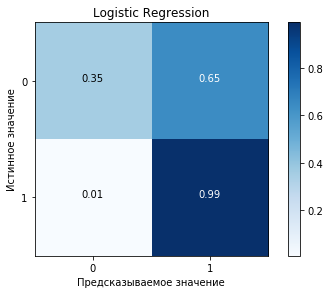

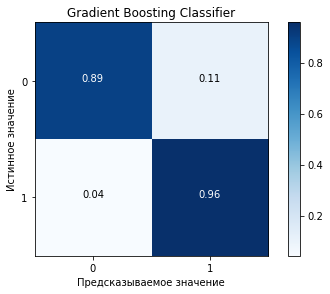

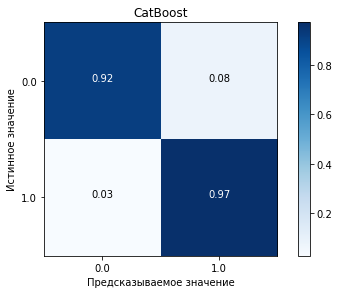

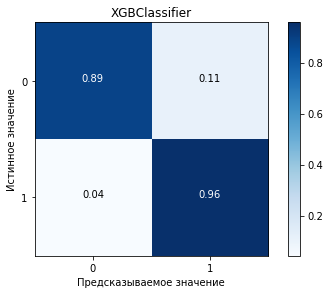

In [13]:
plot_confusion_matrix(
    confusion_matrix(reg_y_test_real, reg_y_test_pred), 
    classes=reg.classes_, 
    normalize=True,
    title='Logistic Regression'
)
plot_confusion_matrix(
    confusion_matrix(gb_y_test_real, gb_y_test_pred), 
    classes=gb.classes_,
    normalize=True,
    title='Gradient Boosting Classifier'
)
plot_confusion_matrix(
    confusion_matrix(cb_y_test_real, cb_y_test_pred), 
    classes=cb.classes_,
    normalize=True,
    title='CatBoost'
)
plot_confusion_matrix(
    confusion_matrix(xgb_y_test_real, xgb_y_test_pred), 
    classes=xgb.classes_,
    normalize=True,
    title='XGBClassifier'
)

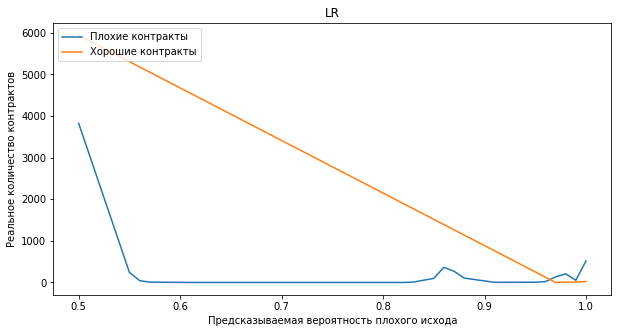

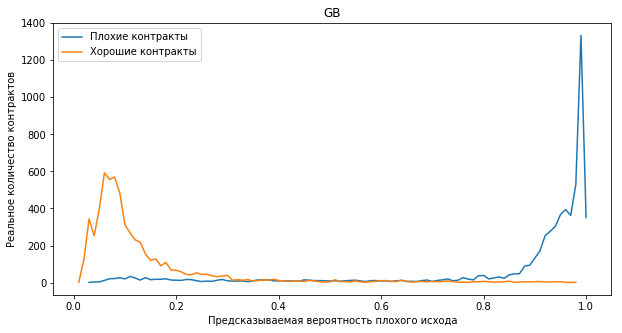

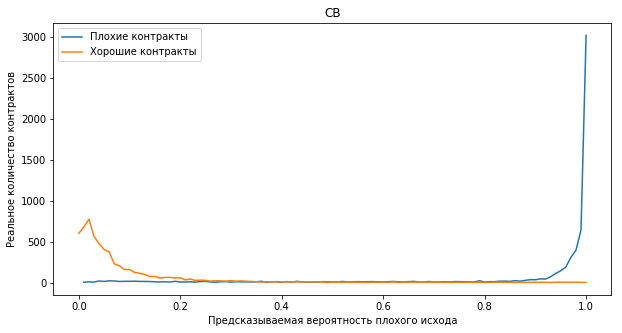

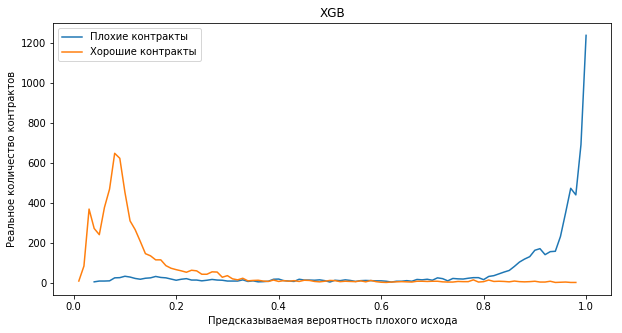

In [14]:
plot_dependence(reg_res, title='LR')
plot_dependence(gb_res, title='GB')
plot_dependence(cb_res, title='CB')
plot_dependence(xgb_res, title='XGB')